# LIF Network

The Network API of sapinet will help to make building a network less cumbersome and prone to errors by handling among other things how information flow through the network (e.g. adding input to the right node/neurons or handling the first iteration of the simulation)

In [34]:
import torch
from sapicore.engine.network import Network
from sapicore.engine.ensemble.spiking import LIFEnsemble, IZEnsemble
from sapicore.engine.synapse.STDP import Synapse, STDPSynapse
# from sapicore.engine.simulation import Simulator
from sapicore.utils.plotting import spike_raster
from sapicore.utils.sweep import Sweep

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

In [36]:
steps = 100

In [37]:
I = torch.ones(steps) * 1000
I[int(steps/2):] = 0
I[:int(steps/5)] = 0

In [38]:
params_ensembles = {
            "random" : 
                {
                'volt_rest': {
                                'method': 'uniform',
                                'args' : [-70.0, 20.0]
                            },
                'volt_thresh': {
                                'method': 'uniform',
                                'args' : [-55.0, 40.0]
                            },
                'leak_gl': {
                                'method': 'uniform',
                                'args' : [3.0, 3.0]
                            },
                'tau_mem': {
                                'method': 'uniform',
                                'args' : [3.0, 3.0]
                            },
                'tau_ref': {
                                'method': 'uniform',
                                'args' : [2.0, 2.0]
                            },
                }
}
num_unit = 5
sweep = Sweep(params_ensembles)

In [39]:
# Define the ensembles
ensemble_0 = LIFEnsemble(identifier = 'ensemble_0', num_units=num_unit)
ensemble_1 = LIFEnsemble(identifier = 'ensemble_1', num_units=num_unit)
ensemble_2 = LIFEnsemble(identifier = 'ensemble_2', num_units=num_unit)

# Heterogeneize each ensemble
sweep.heterogenize(ensemble_0)
sweep.heterogenize(ensemble_1)
sweep.heterogenize(ensemble_2)

Define synaptic connections between each ensembles. Here we don't add supplemtal heterogeneous parameters like we just did with the emsembles, but we could and the same logic would apply.

In [40]:
# First set of synapses
synapse_0_1 = Synapse(identifier = 'synapse_0_1', src_ensemble=ensemble_0, dst_ensemble=ensemble_1,
                        weight_max=50, weight_min=0)
synapse_0_1.weights = torch.rand(ensemble_0.num_units, ensemble_1.num_units) * 100
synapse_0_1.connections = torch.randint(0, 2, (ensemble_0.num_units, ensemble_1.num_units))

# Second set of synapses
synapse_0_2 = Synapse(identifier = 'synapse_0_2', src_ensemble=ensemble_0, dst_ensemble=ensemble_2,
                        weight_max=50, weight_min=0)
synapse_0_2.weights = torch.rand(ensemble_0.num_units, ensemble_2.num_units) * 100
synapse_0_2.connections = torch.randint(0, 2, (ensemble_0.num_units, ensemble_2.num_units))

# Third set of synapses
synapse_1_2 = Synapse(identifier = 'synapse_1_2', src_ensemble=ensemble_1, dst_ensemble=ensemble_2,
                        weight_max=50, weight_min=0)
synapse_1_2.weights = torch.rand(ensemble_1.num_units, ensemble_2.num_units) * 100

Connects all those elements in a network:

In [41]:
# Connect all of those in a Network
custom_network = Network()
custom_network.add_ensembles(ensemble_0, ensemble_1, ensemble_2)
custom_network.add_synapses(synapse_0_1, synapse_0_2, synapse_1_2)

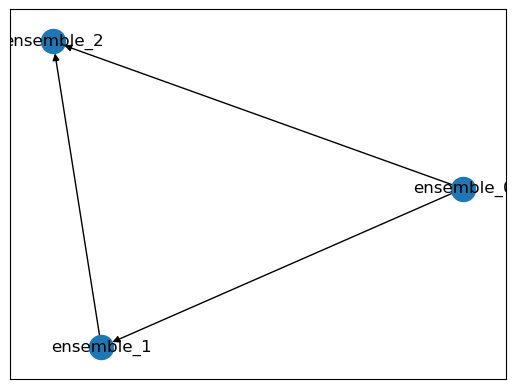

In [42]:
nx.draw_networkx(custom_network.graph)

In [43]:
custom_network.get_ensembles()

[LIFEnsemble(), LIFEnsemble(), LIFEnsemble()]

In [44]:
custom_network.get_synapses()

[Synapse(
   (src_ensemble): LIFEnsemble()
   (dst_ensemble): LIFEnsemble()
 ),
 Synapse(
   (src_ensemble): LIFEnsemble()
   (dst_ensemble): LIFEnsemble()
 ),
 Synapse(
   (src_ensemble): LIFEnsemble()
   (dst_ensemble): LIFEnsemble()
 )]

### Visualizing the connections and weights of Synapse 1 - 2

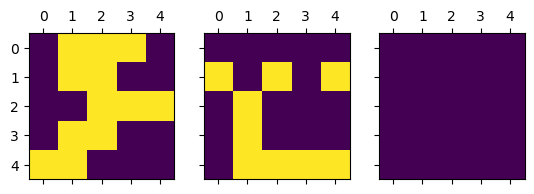

In [45]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)

ax[0].matshow(custom_network.get_synapses()[0].connections)
ax[1].matshow(custom_network.get_synapses()[1].connections)
ax[2].matshow(custom_network.get_synapses()[2].connections)


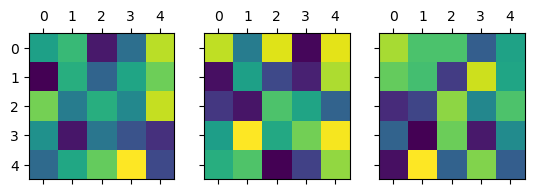

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True)

ax[0].matshow(custom_network.get_synapses()[0].weights)
ax[1].matshow(custom_network.get_synapses()[1].weights)
ax[2].matshow(custom_network.get_synapses()[2].weights)

### Checking which ensemble is considered as the root of our network 

In [47]:
custom_network.roots

['ensemble_0']

### Running the simulation

In [48]:
voltage = []

for i in range(steps):
    input = [I[i].repeat(ensemble_0.num_units)]   # each step's input is passed to all neurons in the root ensemble
    custom_network(input)
    voltage.append([custom_network.get_ensembles()[i].voltage for i in range(len(custom_network.get_ensembles()))])

In [49]:
voltage[0]

[tensor([-61.0993, -75.0000, -75.0000, -75.0000, -75.0000]),
 tensor([-61.0993, -75.0000, -75.0000, -75.0000, -75.0000]),
 tensor([-61.0993, -75.0000, -75.0000, -75.0000, -75.0000])]

In [50]:
voltage_ensemble_0 = [voltage[i][0] for i in range(steps)]
voltage_ensemble_0 = torch.stack((voltage_ensemble_0))
voltage_ensemble_0[0]

tensor([-61.0993, -75.0000, -75.0000, -75.0000, -75.0000])

In [51]:
voltage_ensemble_1 = [voltage[i][1] for i in range(steps)]
voltage_ensemble_1 = torch.stack((voltage_ensemble_1))
voltage_ensemble_1[0]

tensor([-61.0993, -75.0000, -75.0000, -75.0000, -75.0000])

In [52]:
voltage_ensemble_2 = [voltage[i][2] for i in range(steps)]
voltage_ensemble_2 = torch.stack((voltage_ensemble_2))
voltage_ensemble_2[0]

tensor([-61.0993, -75.0000, -75.0000, -75.0000, -75.0000])

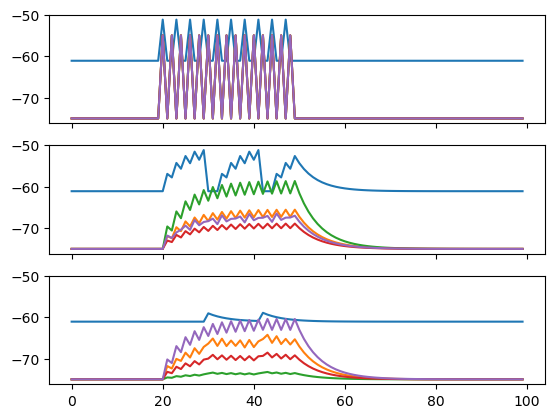

In [53]:
# Plots 

fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True)

ax[0].plot(range(steps), voltage_ensemble_0)
ax[1].plot(range(steps), voltage_ensemble_1)
ax[2].plot(range(steps), voltage_ensemble_2)

plt.show()